In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors as dmj
import math
import random


In [2]:
filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
evermore_shifted = np.asarray([
    [33, 21, 49],
    [154, 112, 82],
    [241, 149, 91],
    [142, 52, 38],
    [33, 21, 49],
])/256

In [25]:
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def reshape_file(hdu, n, inner20 = True):
    """
    Reshapes the data to be in the size we want
    """
    
    if inner20:
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
        inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
        testbin = list(hdu[n].data[inner_20_pos])+list(hdu[n].data[inner_20_neg])
        
        #might need this for plotting, not sure
        #data4 = hdu[n].data
        #test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #testbin = np.reshape(test20, (128*3, 1536//3))

    else:
        """
        testbin = np.reshape(hdu[n].data, (128*3, 1536//3))
        
        """
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        
        inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
        inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
        inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)
        test20[inner_20] = np.nan
        testbin = np.reshape(test20, (128*3, 1536//3))
        
        
    return testbin

def get_energy_index(E_desired, hdu):
    energy_hdu = np.concatenate(hdu[38].data, axis = 0)
    idx = find_nearest(energy_hdu, E_desired)
    return idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

In [26]:
def get_curves(n, energyidx, inner20psf = True):
    icsa = readfile(filelist[n])
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at 50 MeV
    return np.asarray(data50)*3.154e8*1e4*.2 #10 years * 1 m^2 * .2, return in photons /energy/str

In [40]:
icsa = readfile(filelist[2])
data = np.asarray(reshape_file(icsa, 0, inner20 = True))*4*np.pi/196608*3.154e8*1e4*.2 #photons per energy per pixel
print(np.nansum(data)*13.142547540696327)#photons per pixel


661940.6762293355


In [28]:
range_templates = [2, 4, 0]
e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
templates = []
temp = []
deltaomega = 4*np.pi/196608 #i think this should maybe still be total bins in whole image pre-20?
for n in range_templates:
    temp = []
    for index in range(0, len(energies)):
        temp.append(np.nansum(get_curves(n, index)*deltaomega))
    templates.append(np.asarray(temp))
        

In [32]:
print(templates[0])

[5.03662379e+04 5.07473784e+04 4.82986760e+04 4.34744897e+04
 3.69565394e+04 2.93031499e+04 2.11950245e+04 1.42335928e+04
 9.24058993e+03 5.93650694e+03 3.73051255e+03 2.27144947e+03
 1.33179798e+03 7.51638201e+02 4.10460254e+02 2.18857217e+02
 1.14437347e+02 5.86897166e+01 2.96778213e+01 1.48848612e+01
 7.43815669e+00 3.71116381e+00 1.84950500e+00 9.20343046e-01
 4.57035711e-01 2.26309463e-01 1.11617293e-01 5.48016516e-02
 2.67984574e-02 1.30674602e-02 6.36272999e-03 3.09740936e-03
 1.50891253e-03 7.36109753e-04 3.59739054e-04 1.76127571e-04
 8.63751791e-05 4.24102906e-05]


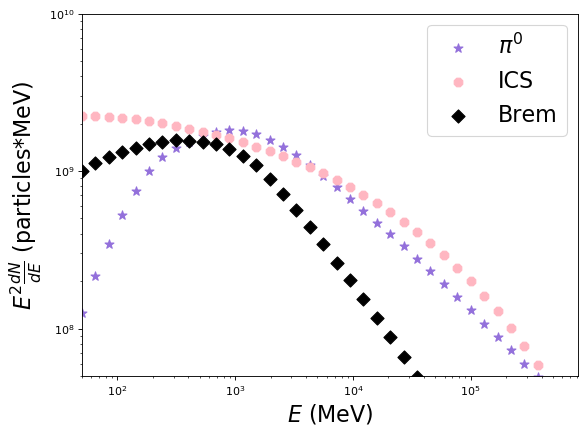

In [31]:
plt.figure(figsize=(8, 6), dpi=80)
dotsize = 70
plt.scatter(energies, energies**2*templates[0], marker = '*', color = 'mediumpurple', label = r'$\pi^{0}$', s = dotsize)
plt.scatter(energies, energies**2*templates[1], marker = '8', color = 'lightpink', label = 'ICS', s = dotsize)
plt.scatter(energies, energies**2*templates[2], marker = 'D', color = 'black', label = 'Brem', s = dotsize)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$E^{2}\frac{dN}{dE}$ (particles*MeV)', fontsize=20)
plt.xlabel(r'$E$ (MeV)', fontsize=20)
plt.legend(fontsize=20)
plt.ylim(5e7, 1e10)
plt.xlim(np.nanmin(energies), np.nanmax(energies))

plt.savefig('brem_ICS_pi_curve_shape.pdf')



In [12]:
print(templates[0])

[1675533.8923475968, 1688213.2955619222, 1606752.3000782644, 1446266.070960531, 1229433.3839112078, 974828.0363290808, 705094.9870254927, 473509.0030083355, 307406.75223187654, 197489.8066673042, 124102.97983297422, 75564.32095897551, 44304.930085370754, 25004.751849823617, 13654.783338200394, 7280.724142824652, 3806.9877897025244, 1952.4311015245582, 987.2922330322424, 495.17475197334653, 247.44519642343238, 123.4593052369091, 61.527492152634096, 30.617056788054715, 15.204209329191102, 7.528638046134644, 3.713173048286072, 1.8230868208542406, 0.8915044188833385, 0.43471526470578253, 0.21166897100204285, 0.10304153306757866, 0.05019700086522119, 0.024488166901846978, 0.011967440940291285, 0.005859236791512122, 0.0028734435208967457, 0.0014108633542978222]
